# Pest Classification with Transfer Learning (EfficientNetBO)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [2]:
dataset_path = '../datasets'

# Parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset='training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset='validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

Found 5494 files belonging to 12 classes.
Using 4396 files for training.
Found 5494 files belonging to 12 classes.
Using 1098 files for validation.


# Data Preprocessing

In [3]:
# Image Augmentation
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# Preprocessing the training data
def preprocess_train_(image, label):
    image = img_augmentation(image)
    return image, label

train_ds_aug = train_ds.map(preprocess_train_)
train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)

# Model Creation

In [4]:
def create_efficientNet(input_shape: tuple, n_classes: int):
    # Input layer
    # inputs = tf.keras.layers.Input(shape=input_shape)

    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, 
        # input_tensor=inputs, 
        weights='imagenet',
        input_shape=input_shape,
    )

    # Freeze the pretrained weights
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.Conv2D(32, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Conv2D(128, 3, activation='relu'),
        # tf.keras.layers.Conv2D(128, 3, activation='relu'),
        # tf.keras.layers.Conv2D(128, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    # x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    # Feature extraction
    # features = model(x)

    # Global Average Pooling layer
    # pool_layer = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Dense blocks
    # x = tf.keras.layers.Dense(32, activation='relu')(pool_layer)
    # x = tf.keras.layers.Dense(64, activation='relu')(x)
    # x = tf.keras.layers.Dense(64, activation='relu')(x)   
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    # x = tf.keras.layers.MaxPooling2D(2, 2)

    # Output layer
    # outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    # model = tf.keras.Model(inputs, outputs)
    return model

In [5]:
efficientNet = create_efficientNet(input_shape=(img_height, img_width, 3), n_classes=12)
efficientNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

# Compiling the Model

In [6]:
efficientNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), 
    # tf.keras.callbacks.ModelCheckpoint('../models/best_efficientNet.h5', monitor='val_loss', mode='min', save_best_only=True)
]

# Model Training

In [7]:
efficientNet_history = efficientNet.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=20,
)

Epoch 1/20
138/138 [==============================] - 26s 111ms/step - loss: 2.0483 - accuracy: 0.6058 - val_loss: 1.0934 - val_accuracy: 0.8852
Epoch 2/20
138/138 [==============================] - 13s 91ms/step - loss: 1.1519 - accuracy: 0.8153 - val_loss: 0.8371 - val_accuracy: 0.9062
Epoch 3/20
138/138 [==============================] - 13s 91ms/step - loss: 0.9468 - accuracy: 0.8528 - val_loss: 0.7378 - val_accuracy: 0.9208
Epoch 4/20
138/138 [==============================] - 13s 94ms/step - loss: 0.8497 - accuracy: 0.8628 - val_loss: 0.6855 - val_accuracy: 0.9171
Epoch 5/20
138/138 [==============================] - 13s 94ms/step - loss: 0.7913 - accuracy: 0.8731 - val_loss: 0.6647 - val_accuracy: 0.9189
Epoch 6/20
138/138 [==============================] - 13s 94ms/step - loss: 0.7369 - accuracy: 0.8933 - val_loss: 0.6335 - val_accuracy: 0.9189
Epoch 7/20
138/138 [==============================] - 13s 91ms/step - loss: 0.7162 - accuracy: 0.8863 - val_loss: 0.6180 - val_accuracy

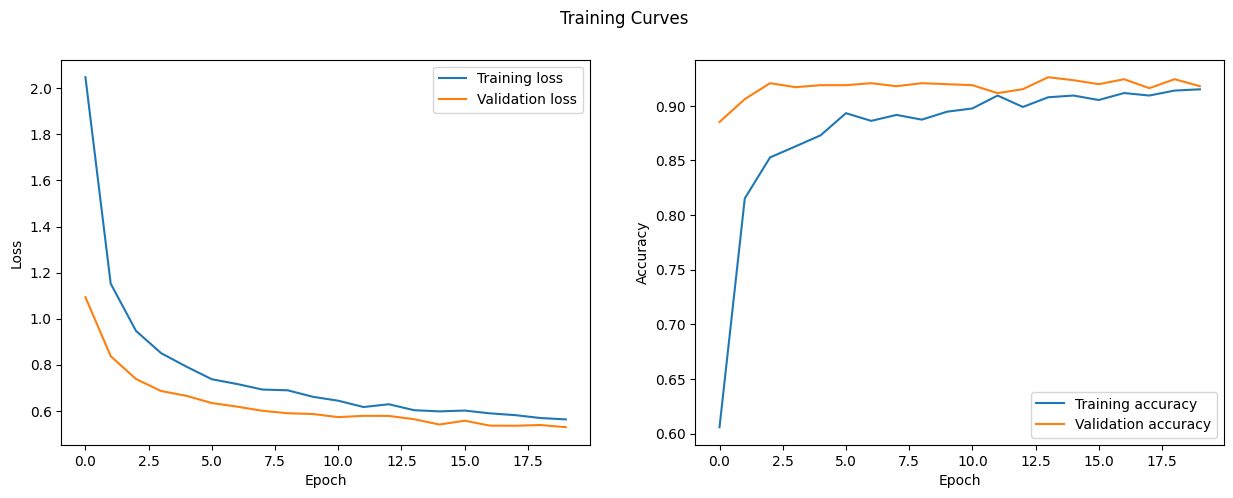

In [8]:
history = efficientNet_history.history

plt.figure(figsize=(15, 5))  # Size of the complete figure
plt.subplot(1, 2, 1)  # Select first subplot
plt.plot(history['loss'], label='Training loss') 
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)  # Select second subplot
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.legend(loc='lower right')  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.suptitle('Training Curves')  # Centered title for the figure
plt.show()

In [9]:
def show_performance_evaluation(model, datasets: list):
    for dataset in datasets:
        y_true = []
        y_pred = []
        for images, labels in dataset:
            y_true_batch = np.argmax(labels, axis=-1)  # Convert one-hot encoded labels back to integer labels
            y_pred_batch = np.argmax(model.predict(images), axis=-1)

            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ----- Plotting a confusion matrix with seaborn ----- #
        plt.figure(figsize=(15, 8)) 
        class_names = dataset.class_names
        ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=class_names, yticklabels=class_names)  # Seaborn heatmap
        ax.set_title('Confusion Matrix') 
        plt.show()

        print('\n\nClassification Report:\n')
        print(classification_report(y_true, y_pred, labels=[i for i in range(0, 12)], target_names=class_names))

1/1 [==============================] - 2s 2s/step


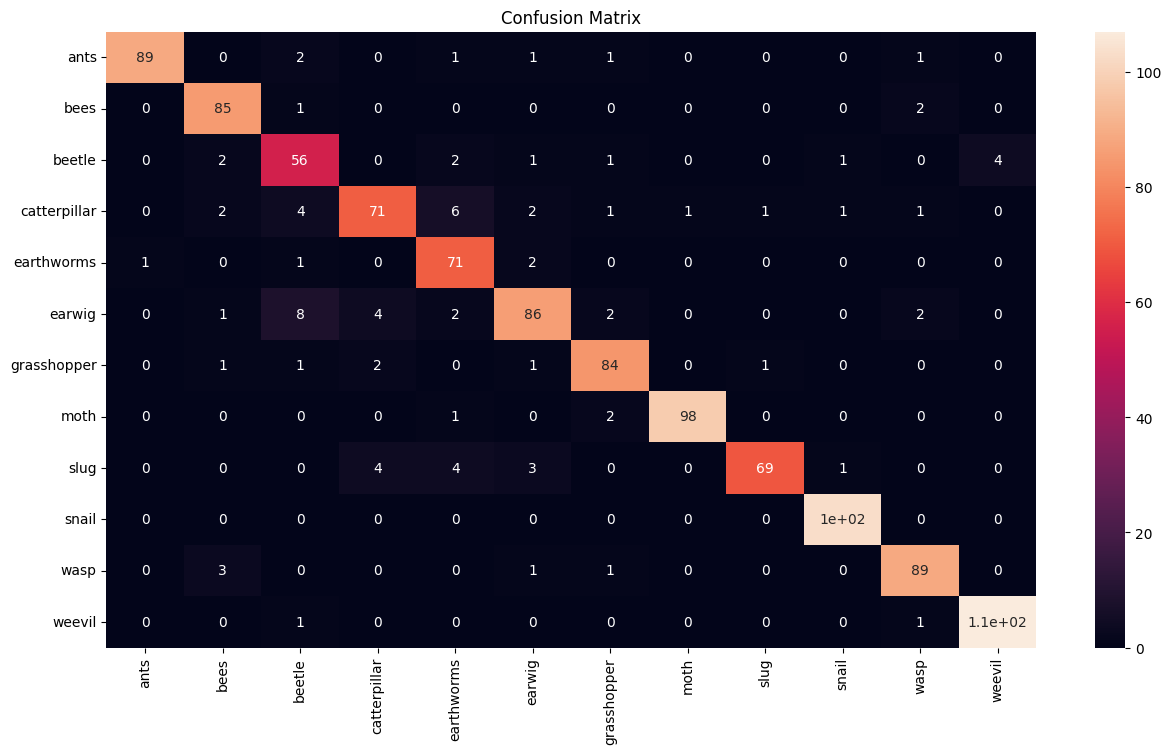



Classification Report:

              precision    recall  f1-score   support

        ants       0.99      0.94      0.96        95
        bees       0.90      0.97      0.93        88
      beetle       0.76      0.84      0.79        67
catterpillar       0.88      0.79      0.83        90
  earthworms       0.82      0.95      0.88        75
      earwig       0.89      0.82      0.85       105
 grasshopper       0.91      0.93      0.92        90
        moth       0.99      0.97      0.98       101
        slug       0.97      0.85      0.91        81
       snail       0.97      1.00      0.99       103
        wasp       0.93      0.95      0.94        94
      weevil       0.96      0.98      0.97       109

    accuracy                           0.92      1098
   macro avg       0.91      0.91      0.91      1098
weighted avg       0.92      0.92      0.92      1098



In [10]:
show_performance_evaluation(datasets=[val_ds], model=efficientNet)